### **To what extent is the growth of nestling blue tits (Cyanistes caeruleus) influenced by competition with siblings?**
#### Project - *Same data, different analysts: variation in effect sizes due to analytical decisions in ecology and evolutionary biology*

Libraries

In [17]:
require (dplyr)
require (visreg)
require (lme4)
require (sjPlot)
require (ggplot2)
require (cowplot)
require (MuMIn)

Functions

In [18]:
as.num.fact <- function(x) {   #Convert numeric factor into real number
  as.numeric(as.character(x))
}

Data

In [19]:
blue_tit_data=read.csv ("blue_tit_data_updated_2020-04-18.csv")
head(blue_tit_data)

,chick_ring_number,hatch_year,hatch_nest_breed_ID,hatch_Area,hatch_Box,hatch_mom_Ring,hatch_nest_dad_Ring,Extra.pair_paternity,Extra.pair_dad_ring,genetic_dad_ring_.WP_or_EP.,...,net_rearing_manipulation,rear_Cs_at_start_of_rearing,d14_rear_nest_brood_size,number_chicks_fledged_from_rear_nest,Date_of_day14,day_14_tarsus_length,day_14_weight,day14_measurer,chick_sex_molec,chick_survival_to_first_breed_season
,<fct>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,...,<fct>,<fct>,<int>,<fct>,<int>,<dbl>,<dbl>,<int>,<fct>,<int>
1,P804016,2001,201194,C,C130,P803008,P803007,1,.,.,...,3,12,12,12,54,16.6,8.0,1,2,0
2,P804017,2001,201194,C,C130,P803008,P803007,2,.,P803007,...,3,12,12,12,54,15.5,8.1,1,2,0
3,P804018,2001,201167,C,C26,P803005,P803006,2,.,P803006,...,3,12,12,12,54,17.1,10.3,1,2,0
4,P804019,2001,201194,C,C130,P803008,P803007,2,.,P803007,...,3,12,12,12,54,17.6,8.4,1,1,0
5,P804020,2001,201167,C,C26,P803005,P803006,2,.,P803006,...,3,12,12,12,54,16.3,8.1,1,1,0
6,P804021,2001,201194,C,C130,P803008,P803007,2,.,P803007,...,3,12,12,12,54,16.4,8.4,1,2,0


Correct variables types

In [20]:
blue_tit_data=within (blue_tit_data,{
    rear_Cs_at_start_of_rearing = as.num.fact (rear_Cs_at_start_of_rearing)
    number_chicks_fledged_from_rear_nest = as.num.fact(number_chicks_fledged_from_rear_nest)
    rear_d0_rear_nest_brood_size = as.num.fact (rear_d0_rear_nest_brood_size)
    d14_rear_nest_brood_size = as.num.fact (d14_rear_nest_brood_size)
    rear_nest_LD = as.num.fact (rear_nest_LD)
    number_chicks_fledged_from_rear_nest = as.num.fact(number_chicks_fledged_from_rear_nest)
    day_14_tarsus_length = as.num.fact(day_14_tarsus_length)
    day_14_weight = as.num.fact(day_14_weight)
    net_rearing_manipulation= as.num.fact(net_rearing_manipulation)
    hatch_nest_CS= as.num.fact(hatch_nest_CS)
    rear_area=factor (rear_area)
    rear_Box=factor (rear_Box)
    home_or_away=factor(home_or_away)
  })

Warning message in as.num.fact(rear_Cs_at_start_of_rearing):
"NAs introduzidos por coerção"
Warning message in as.num.fact(number_chicks_fledged_from_rear_nest):
"NAs introduzidos por coerção"
Warning message in as.num.fact(rear_d0_rear_nest_brood_size):
"NAs introduzidos por coerção"
Warning message in as.num.fact(rear_nest_LD):
"NAs introduzidos por coerção"
Warning message in as.num.fact(net_rearing_manipulation):
"NAs introduzidos por coerção"
Warning message in as.num.fact(hatch_nest_CS):
"NAs introduzidos por coerção"


#### **Analysis at the "population level" (nests were considered sampling units)**
#### *In this first approach, I'm going to test the influence of the number of live chicks in the nest (proxy for intraspecific competition) on the average and variance of chick's mass at day 14 (proxy for growth), and on the number of chicks that survived to leave the nest*

Define a variable that separates manipulated and non-manipulated nests. 
Remove variables that we are not going to use for this approach

In [22]:
blue_tit_data$Treatment=ifelse(blue_tit_data$rear_nest_trt=='5' |
                               blue_tit_data$rear_nest_trt=='6', 'Yes','No')

pop_data=blue_tit_data[,c("rear_Cs_at_start_of_rearing",
                          "d14_rear_nest_brood_size",
                          "number_chicks_fledged_from_rear_nest",
                          "day_14_tarsus_length",
                          "day_14_weight",
                          "rear_nest_LD",
                          "rear_area",
                          "rear_Box",
                          "Treatment",
                          "net_rearing_manipulation")]

Calculate average and standard deviation for the variables according to each nest box. Note that for some variables, sd will be zero because the variables were measured at the population level (e.g., number_chicks_fledged_from_rear_nest)

In [23]:
pop_data=pop_data %>% 
  group_by(rear_Box, rear_area,Treatment) %>% 
  summarise_all(.funs = list(Mean= ~ mean(x=.),
                             Sd= ~sd (x=.)))

Explore the correlation between:

* Number of live chicks in the nest at day 14 after hatching (d14_rear_nest_brood_size) and the number of chicks in nest at day 0 (rear_Cs_at_start_of_rearing). These two variables are proxies for the number of chicks in the nests. 
* Number of live chicks in the nest at day 0 and the net change in chick number in nest where chick reared. These variables are expected to correlated given that net changes in chick number are directly related with the final number of chicks in the nest (i.e., if you remove chicks from the nest, the number of chicks of the nest is reduced and vice-versa). Non-manipulated nests will have NAs for net changes in chicks' number.
* Tarsus average length (mm) and average mass of chicks (g) at day 14. These two variables are proxies for the average growth of chicks.   

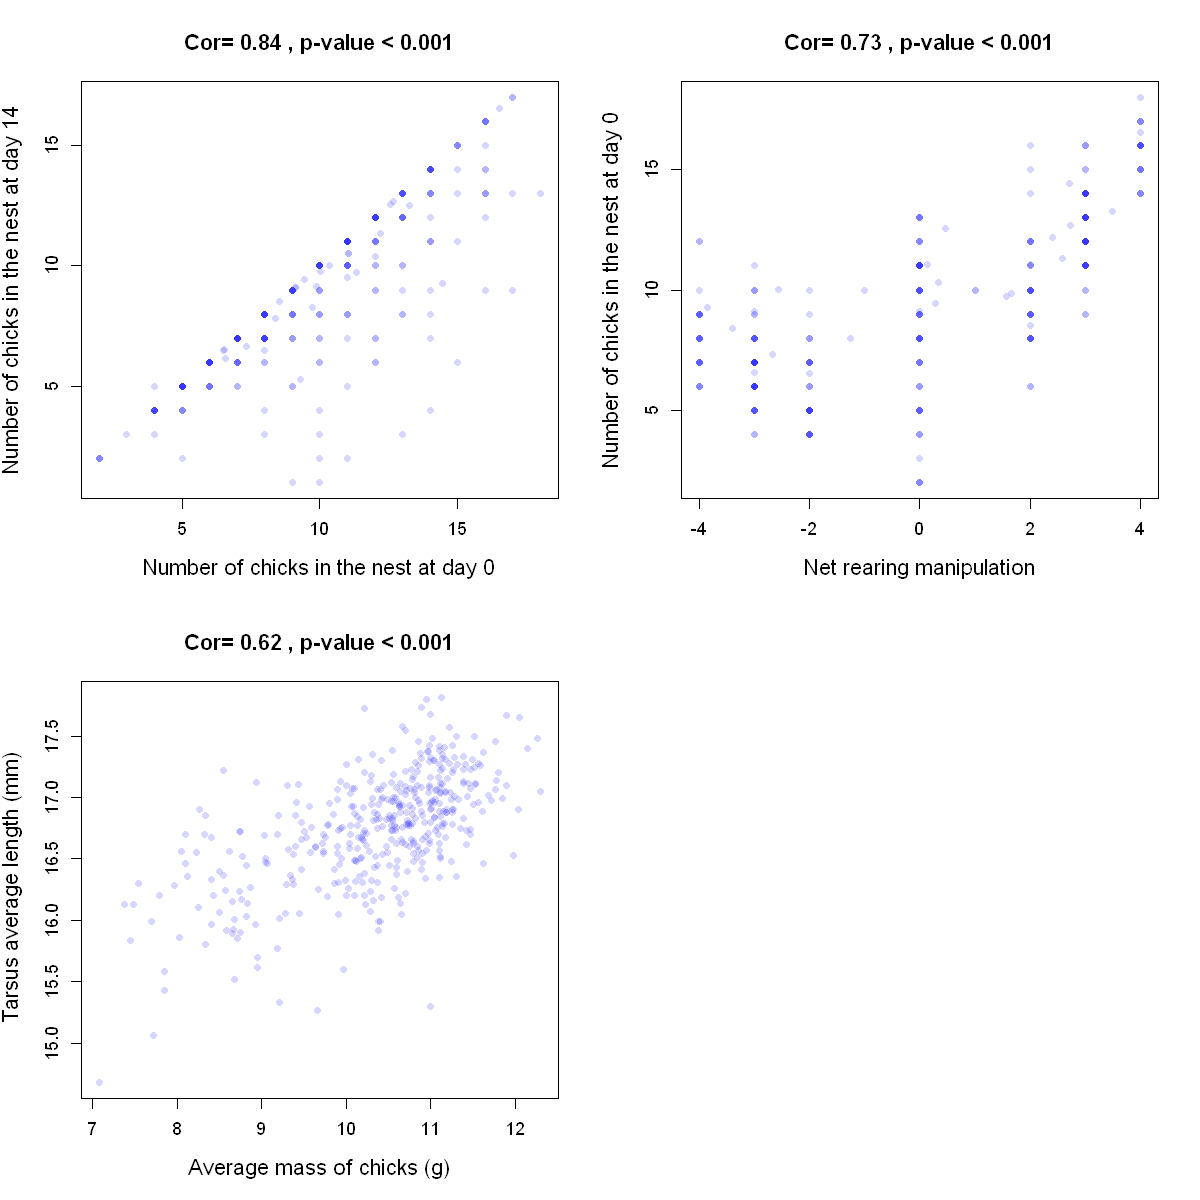

In [24]:
options(repr.plot.width=10, repr.plot.height=10)
par (mfrow=c(2,2))
cor_test1=cor.test (pop_data$d14_rear_nest_brood_size_Mean,
                    pop_data$rear_Cs_at_start_of_rearing_Mean)
plot(d14_rear_nest_brood_size_Mean~rear_Cs_at_start_of_rearing_Mean,
     data=pop_data,main=paste('Cor=' ,round(cor_test1$estimate,2), 
                              ", p-value", ifelse(cor_test1$p.value<0.001,
                                                  "< 0.001",round(cor_test1$p.value,3))),
    ylab= "Number of chicks in the nest at day 14",
    xlab= "Number of chicks in the nest at day 0",
    cex.axis=1.1, cex.lab=1.3,cex.main=1.3,
    pch=16, col=rgb(red=0.2, green=0.2, blue=1.0, alpha=0.2))

cor_test2=cor.test (pop_data$rear_Cs_at_start_of_rearing_Mean,
                    pop_data$net_rearing_manipulation_Mean)
plot(rear_Cs_at_start_of_rearing_Mean~net_rearing_manipulation_Mean,
     data=pop_data,main=paste('Cor=' ,round(cor_test2$estimate,2), 
                              ", p-value", ifelse(cor_test2$p.value<0.001,
                                                  "< 0.001",round(cor_test2$p.value,3))),
    ylab= "Number of chicks in the nest at day 0",
    xlab= "Net rearing manipulation",
    cex.axis=1.1, cex.lab=1.3,cex.main=1.3,
    pch=16, col=rgb(red=0.2, green=0.2, blue=1.0, alpha=0.2))

cor_test3=cor.test (pop_data$day_14_tarsus_length_Mean,
                    pop_data$day_14_weight_Mean)
plot(pop_data$day_14_tarsus_length_Mean~pop_data$day_14_weight_Mean,
     data=pop_data,main=paste('Cor=' ,round(cor_test3$estimate,2), 
                              ", p-value", ifelse(cor_test3$p.value<0.001,
                                                  "< 0.001",round(cor_test3$p.value,3))),
    ylab=" Tarsus average length (mm)",
    xlab="Average mass of chicks (g)",
    cex.axis=1.1, cex.lab=1.3,cex.main=1.3,
    pch=16, col=rgb(red=0.2, green=0.2, blue=1.0, alpha=0.2))

All pair of variables are strongly correlated. In order to avoid multicolinearity in my analysis, I will use:
* The number of chicks in nest at day 0 (rear_Cs_at_start_of_rearing) as a single proxy for intraspecific competition.  
* Mass of chicks at day 14 (day_14_weight_Mean) as a single proxy for chicks growth. 

In [25]:
pop_data= subset(pop_data, select=-c(d14_rear_nest_brood_size_Mean,
                                     day_14_tarsus_length_Mean,
                                     net_rearing_manipulation_Mean
                                    ))
pop_data= na.omit(pop_data) # Remove NAs

Convert some variable into integers and calculate the coefficient of variance of chicks' mass

In [26]:
pop_data$number_chicks_fledged_from_rear_nest=as.integer(pop_data$number_chicks_fledged_from_rear_nest_Mean)
pop_data$rear_Cs_at_start_of_rearing=as.integer(pop_data$rear_Cs_at_start_of_rearing_Mean)
pop_data$day_14_weight_CV= (pop_data$day_14_weight_Sd/pop_data$day_14_weight_Mean)

Now, I'm going to model the influence of the number of chicks in the nests on the response variables: average growth, coefficient variance of average growth, and chicks survivorship. I'm going to conduct univariate models. For each response variable, two models will be conducted: one with a single exploratory variable(the number of chicks in the nests), and another with one exploratory variable (the number of chicks in the nests) and three co-variables (rear area,the date of the first egg was laid, and treatment [manipulated or non-manipulated]).

In [27]:
# Average growth model - without co-variables
Model_mean_growth=lm (day_14_weight_Mean~rear_Cs_at_start_of_rearing,
                      data=pop_data)
(Summary_MMeangrowth=summary(Model_mean_growth))


Call:
lm(formula = day_14_weight_Mean ~ rear_Cs_at_start_of_rearing, 
    data = pop_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.1413 -0.4127  0.2123  0.6077  1.5231 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)    
(Intercept)                 11.57604    0.13506  85.708   <2e-16 ***
rear_Cs_at_start_of_rearing -0.13292    0.01346  -9.872   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.8629 on 351 degrees of freedom
Multiple R-squared:  0.2173,	Adjusted R-squared:  0.2151 
F-statistic: 97.45 on 1 and 351 DF,  p-value: < 2.2e-16


In [28]:
# Average growth model - with co-variables
Model_mean_growth_cov=lm (day_14_weight_Mean~rear_Cs_at_start_of_rearing+
                            rear_area+rear_nest_LD_Mean+Treatment,
                      data=pop_data)
(Summary_MMeangrowth_cov=summary(Model_mean_growth_cov))


Call:
lm(formula = day_14_weight_Mean ~ rear_Cs_at_start_of_rearing + 
    rear_area + rear_nest_LD_Mean + Treatment, data = pop_data)

Residuals:
   Min     1Q Median     3Q    Max 
-2.770 -0.413  0.136  0.545  1.469 

Coefficients:
                             Estimate Std. Error t value Pr(>|t|)    
(Intercept)                 12.258617   0.224431  54.621  < 2e-16 ***
rear_Cs_at_start_of_rearing -0.158491   0.013621 -11.635  < 2e-16 ***
rear_areaC                   0.126286   0.153849   0.821 0.412307    
rear_areaCP                  0.323286   0.185914   1.739 0.082955 .  
rear_areaE                   0.733059   0.196528   3.730 0.000224 ***
rear_areaMP                  0.199921   0.160263   1.247 0.213087    
rear_areaO                   0.425679   0.143323   2.970 0.003188 ** 
rear_areaP                   0.294863   0.288050   1.024 0.306725    
rear_areaSW                  0.173640   0.157437   1.103 0.270840    
rear_areaW                   0.699197   0.172636   4.050 6.34e-05

In [29]:
#Growth variation model - without co-variables
Model_CV_growth=lm (day_14_weight_CV~rear_Cs_at_start_of_rearing,
                    data=pop_data)
(Summary_MCVgrowth=summary(Model_CV_growth))


Call:
lm(formula = day_14_weight_CV ~ rear_Cs_at_start_of_rearing, 
    data = pop_data)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.052893 -0.021724 -0.007455  0.010642  0.215853 

Coefficients:
                             Estimate Std. Error t value Pr(>|t|)    
(Intercept)                 0.0355514  0.0050728   7.008 1.24e-11 ***
rear_Cs_at_start_of_rearing 0.0033144  0.0005057   6.554 2.00e-10 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.03241 on 351 degrees of freedom
Multiple R-squared:  0.109,	Adjusted R-squared:  0.1065 
F-statistic: 42.96 on 1 and 351 DF,  p-value: 2e-10


In [30]:
#Growth variation model - with co-variables
Model_CV_growth_cov=lm (day_14_weight_CV~rear_Cs_at_start_of_rearing+
                            rear_area+rear_nest_LD_Mean+Treatment,
                          data=pop_data)
(Summary_MCVgrowth_cov=summary(Model_CV_growth_cov))


Call:
lm(formula = day_14_weight_CV ~ rear_Cs_at_start_of_rearing + 
    rear_area + rear_nest_LD_Mean + Treatment, data = pop_data)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.056097 -0.020900 -0.006449  0.012310  0.204016 

Coefficients:
                              Estimate Std. Error t value Pr(>|t|)    
(Intercept)                  0.0184219  0.0088368   2.085   0.0378 *  
rear_Cs_at_start_of_rearing  0.0037449  0.0005363   6.982 1.53e-11 ***
rear_areaC                   0.0042470  0.0060577   0.701   0.4837    
rear_areaCP                 -0.0034952  0.0073203  -0.477   0.6333    
rear_areaE                  -0.0195677  0.0077382  -2.529   0.0119 *  
rear_areaMP                 -0.0018216  0.0063103  -0.289   0.7730    
rear_areaO                  -0.0095082  0.0056433  -1.685   0.0929 .  
rear_areaP                  -0.0022925  0.0113418  -0.202   0.8399    
rear_areaSW                 -0.0053304  0.0061990  -0.860   0.3905    
rear_areaW                 

In [31]:
#Survival Model - Without co-variables
Model_mean_Surv= glm (cbind(number_chicks_fledged_from_rear_nest,
                            rear_Cs_at_start_of_rearing)~
                      rear_Cs_at_start_of_rearing,
                      data=pop_data,family="binomial")
(Summary_MSurv=summary(Model_mean_Surv))
cat('In-sample R2 =')
round (1 - (Model_mean_Surv$deviance/Model_mean_Surv$null.deviance),2) 



Call:
glm(formula = cbind(number_chicks_fledged_from_rear_nest, rear_Cs_at_start_of_rearing) ~ 
    rear_Cs_at_start_of_rearing, family = "binomial", data = pop_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.0837  -0.0914   0.1436   0.2734   0.7328  

Coefficients:
                             Estimate Std. Error z value Pr(>|z|)  
(Intercept)                  0.009136   0.084654   0.108   0.9141  
rear_Cs_at_start_of_rearing -0.015342   0.007633  -2.010   0.0444 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 174.49  on 352  degrees of freedom
Residual deviance: 170.45  on 351  degrees of freedom
AIC: 1307.1

Number of Fisher Scoring iterations: 3


In-sample R2 =

[1] 0.02

In [32]:
#Survival Model - With co-variables
Model_mean_Surv_cov=glm (cbind(number_chicks_fledged_from_rear_nest,
                               rear_Cs_at_start_of_rearing)~
                           rear_Cs_at_start_of_rearing+
                           rear_area+rear_nest_LD_Mean+Treatment,
                         data=pop_data,family="binomial")

(Summary_MSurv_cov=summary(Model_mean_Surv_cov))
cat('In-sample R2 =')
round (1 - (Model_mean_Surv_cov$deviance/Model_mean_Surv_cov$null.deviance),2) 



Call:
glm(formula = cbind(number_chicks_fledged_from_rear_nest, rear_Cs_at_start_of_rearing) ~ 
    rear_Cs_at_start_of_rearing + rear_area + rear_nest_LD_Mean + 
        Treatment, family = "binomial", data = pop_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.0224  -0.1185   0.1292   0.2627   0.8804  

Coefficients:
                             Estimate Std. Error z value Pr(>|z|)  
(Intercept)                  0.093093   0.140579   0.662   0.5078  
rear_Cs_at_start_of_rearing -0.018979   0.008187  -2.318   0.0204 *
rear_areaC                   0.079277   0.090248   0.878   0.3797  
rear_areaCP                  0.026155   0.118139   0.221   0.8248  
rear_areaE                   0.110002   0.110895   0.992   0.3212  
rear_areaMP                  0.070517   0.096478   0.731   0.4648  
rear_areaO                   0.073184   0.085587   0.855   0.3925  
rear_areaP                   0.061428   0.163442   0.376   0.7070  
rear_areaSW                  0.001068 

In-sample R2 =

[1] 0.05

Visualize the effect of the number of chicks in the nests on our response variables according to the models created. 

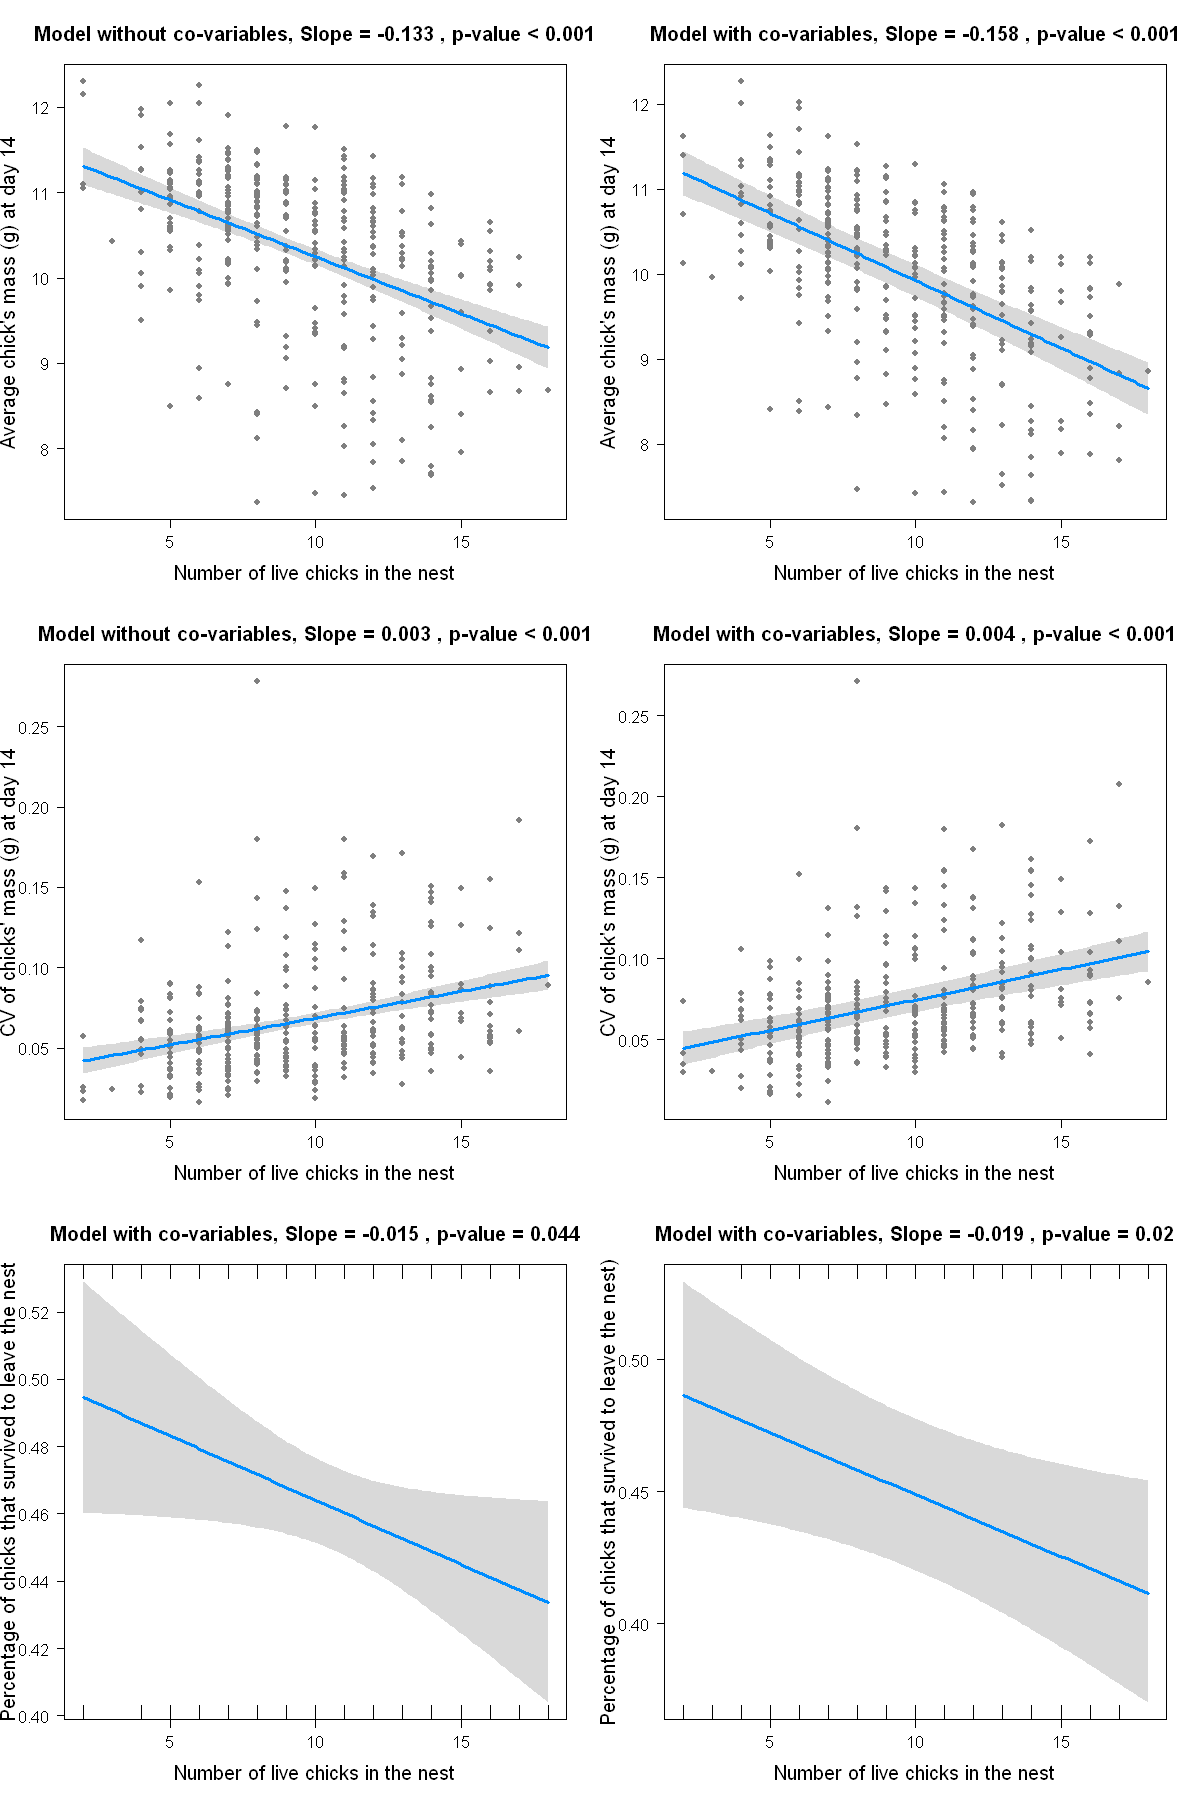

In [33]:
options(repr.plot.width=10, repr.plot.height=15)
par(mfrow=c(3,2))

# Average growth models
visreg(Model_mean_growth, xlab="Number of live chicks in the nest", 
       ylab="Average chick's mass (g) at day 14",
       cex.axis=1.2, cex.lab=1.5,cex.main=1.5,points=list(cex=1.6, pch=20),
       main=paste("Model without co-variables,",
                  "Slope =", round(Summary_MMeangrowth$coefficients[2,1],3),
                  ", p-value", ifelse(Summary_MMeangrowth$coefficients[2,4]<0.001,
                                      "< 0.001",paste("=",round(Summary_MMeangrowth$coefficients[2,4],3))))
       ) 



visreg(Model_mean_growth_cov,xvar="rear_Cs_at_start_of_rearing", 
       xlab="Number of live chicks in the nest", 
       ylab="Average chick's mass (g) at day 14",
       cex.axis=1.2, cex.lab=1.5,cex.main=1.5,points=list(cex=1.6, pch=20),
       main=paste("Model with co-variables,",
                  "Slope =", round(Summary_MMeangrowth_cov$coefficients[2,1],3),
                  ", p-value", ifelse(Summary_MMeangrowth_cov$coefficients[2,4]<0.001,
                                      "< 0.001",paste("=",round(Summary_MMeangrowth_cov$coefficients[2,4],3))))
       )

# Growth variation models
visreg(Model_CV_growth, xlab="Number of live chicks in the nest", 
       ylab="CV of chicks' mass (g) at day 14",
       cex.axis=1.2, cex.lab=1.5,cex.main=1.5,points=list(cex=1.6, pch=20),
       main=paste("Model without co-variables,",
                  "Slope =", round(Summary_MCVgrowth$coefficients[2,1],3),
                  ", p-value", ifelse(Summary_MCVgrowth$coefficients[2,4]<0.001,
                                      "< 0.001",paste("=",round(Summary_MCVgrowth$coefficients[2,4],3))))
)

visreg(Model_CV_growth_cov,xvar="rear_Cs_at_start_of_rearing", 
       xlab="Number of live chicks in the nest", 
       ylab="CV of chick's mass (g) at day 14",
       cex.axis=1.2, cex.lab=1.5,cex.main=1.5,points=list(cex=1.6, pch=20),
       main=paste("Model with co-variables,",
                  "Slope =", round(Summary_MCVgrowth_cov$coefficients[2,1],3),
                  ", p-value", ifelse(Summary_MCVgrowth_cov$coefficients[2,4]<0.001,
                                      "< 0.001",paste("=",round(Summary_MCVgrowth_cov$coefficients[2,4],3))))
       )

# Survival models
visreg(Model_mean_Surv,scale="response",rug=2,ylab="",
       xlab="Number of live chicks in the nest",
       ylab="Percentage of chicks that survived to leave the nest",
       cex.axis=1.2, cex.lab=1.5,cex.main=1.5,points=list(cex=1.6, pch=20),
       main=paste("Model with co-variables,",
                  "Slope =", round(Summary_MSurv$coefficients[2,1],3),
                  ", p-value", ifelse(Summary_MSurv$coefficients[2,4]<0.001,
                                      "< 0.001",paste("=",round(Summary_MSurv$coefficients[2,4],3))))
       )

visreg(Model_mean_Surv_cov,scale="response",rug=2,
       xvar="rear_Cs_at_start_of_rearing",
       xlab="Number of live chicks in the nest",
       ylab="Percentage of chicks that survived to leave the nest)",
       cex.axis=1.2, cex.lab=1.5,cex.main=1.5,points=list(cex=1.6, pch=20),
       main=paste("Model with co-variables,",
                  "Slope =", round(Summary_MSurv_cov$coefficients[2,1],3),
                  ", p-value", ifelse(Summary_MSurv_cov$coefficients[2,4]<0.001,
                                      "< 0.001",paste("=",round(Summary_MSurv_cov$coefficients[2,4],3))))
                  )

These results indicate that intraspecific competition has a significant effect on the growth (average and variation) and survivorship of nestling blue tits. These effects were still significant after accounting for potential confounding variables related to environmental conditions. However, it should be highlighted that the relationship among the variables is usually weak, especially for growth variance and survivorship.

#### **Analysis at the "individual level" (chicks were considered sampling units)**
#### *In this second approach, I'm going to explore how clutch size and number of live chicks in the nest affect chick's mass at day 14 (a proxy for growth) and chick's survival to the first breeding season. For this analysis, I'm only going to use nests that were manipulated. This was necessary to tear apart the effects of clutch size (hatch_nest_CS) and the competition with other life chicks (net_rearing_manipulation). Clutch size reflects exploitative competition at early life stages, when the resources of the mother are divided into different eggs. On the other hand, number of live chicks in the nest (here manipulated experimentally) is related to interference competition for food that is brought to the nest by the father.*

Subset data

In [36]:
ind_data=subset(blue_tit_data, rear_nest_trt=='5' | rear_nest_trt=='6')

Retain only variables that will be used in this approach.

In [37]:
ind_data=blue_tit_data[,c("chick_survival_to_first_breed_season",
                          "day_14_weight",
                          "rear_Cs_at_start_of_rearing",
                          "hatch_nest_CS",
                          "rear_Box",
                          "hatch_Box",
                          "net_rearing_manipulation",
                          "rear_area",
                          "rear_nest_LD",
                          "home_or_away"
                          )]
ind_data=na.omit(ind_data) # remove Nas

Explore the correlation between our two main exploratory variables

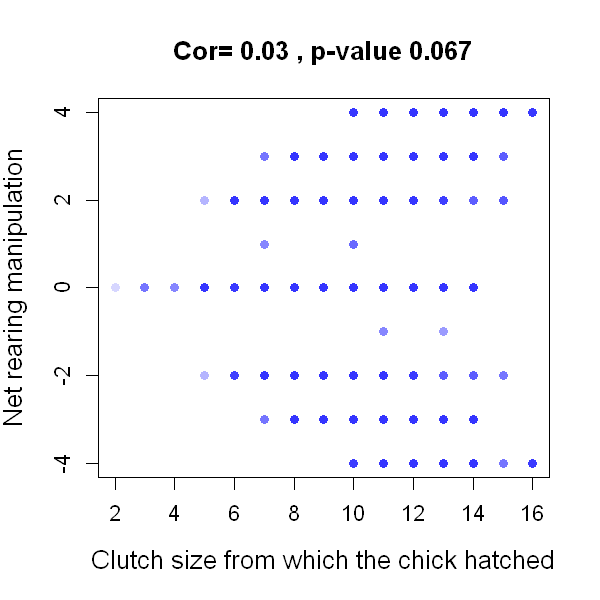

In [38]:
options(repr.plot.width=5, repr.plot.height=5)
par (mfrow=c(1,1))
cor_test4=cor.test (ind_data$net_rearing_manipulation,ind_data$hatch_nest_CS)
plot (ind_data$net_rearing_manipulation~ind_data$hatch_nest_CS,
      cex.axis=1.1, cex.lab=1.3,cex.main=1.3,
      pch=16, col=rgb(red=0.2, green=0.2, blue=1.0, alpha=0.2),
      ylab= "Net rearing manipulation",
      xlab= "Clutch size from which the chick hatched",
      main=paste('Cor=' ,round(cor_test4$estimate,2), 
                 ", p-value", ifelse(cor_test4$p.value<0.001,
                                     "< 0.001",round(cor_test4$p.value,3))))

The correlation is weak and non-significant. So, we can proceed to our main analysis. For this individual approach, we are going to use (generalized) linear mixed models to explore variation in chicks’ weight and survival. This is necessary in order to incorporate the lack of independency between sample units (in this case, chicks). Individual chicks cannot be considered independent units because multiple chicks from the same nests were measured. For each response variable, two models will be conducted: one with two exploratory variable (net rearing manipulation and clutch size from which the chick hatched), and another with two exploratory variable (net rearing manipulation and clutch size from which the chick hatched and three co-variables (rear area, the date of the first egg was laid, and whether the chick was reared in the nest in which it hatched or had been moved by an experimenter to another nest). In all cases, rear nest box ID will be considered as a random variable (random intercept).

In [39]:
# Growth model - without co-variables
model_id_growth= lmer (day_14_weight~hatch_nest_CS+
                    net_rearing_manipulation+ 
                    (1|rear_Box),
                    data=ind_data,REML=FALSE)
(Summary_MIG = summary(model_id_growth))
cat ("\nMarginal R2 (R2m) and Conditional (R2c)")
r.squaredGLMM(model_id_growth)
#calculate p values for the exploratory variables
model_id_growth0_1= update(model_id_growth,. ~ . -net_rearing_manipulation) 
model_id_growth0_2= update(model_id_growth,. ~ . -hatch_nest_CS) 
sig1=anova(model_id_growth,model_id_growth0_1)[2,8]
sig2=anova(model_id_growth,model_id_growth0_2)[2,8]

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: day_14_weight ~ hatch_nest_CS + net_rearing_manipulation + (1 |  
    rear_Box)
   Data: ind_data

     AIC      BIC   logLik deviance df.resid 
  8339.6   8370.1  -4164.8   8329.6     3258 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.0680 -0.5252  0.0552  0.6083  3.6941 

Random effects:
 Groups   Name        Variance Std.Dev.
 rear_Box (Intercept) 0.6048   0.7777  
 Residual             0.5926   0.7698  
Number of obs: 3263, groups:  rear_Box, 342

Fixed effects:
                         Estimate Std. Error t value
(Intercept)              10.83167    0.12822  84.477
hatch_nest_CS            -0.05045    0.01172  -4.303
net_rearing_manipulation -0.15793    0.01149 -13.743

Correlation of Fixed Effects:
            (Intr) ht__CS
htch_nst_CS -0.937       
nt_rrng_mnp  0.039 -0.053


Marginal R2 (R2m) and Conditional (R2c)

R2m,R2c
0.1433842,0.576026


In [40]:
# Growth model - with co-variables
model_id_growth_cov= lmer (day_14_weight~hatch_nest_CS+
                    net_rearing_manipulation+
                    rear_area+rear_nest_LD+home_or_away+
                    (1|rear_Box),
                    data=ind_data,REML=FALSE)
(Summary_MIG_cov = summary(model_id_growth_cov))
cat ("\nMarginal R2 (R2m) and Conditional (R2c)")
r.squaredGLMM(model_id_growth_cov)

#calculate p values for the exploratory variables
model_id_growth0_1_cov= update(model_id_growth_cov,. ~ . -net_rearing_manipulation) 
model_id_growth0_2_cov= update(model_id_growth_cov,. ~ . -hatch_nest_CS) 
sig1_cov=anova(model_id_growth_cov,model_id_growth0_1_cov)[2,8]
sig2_cov=anova(model_id_growth_cov,model_id_growth0_2_cov)[2,8]


Correlation matrix not shown by default, as p = 13 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: 
day_14_weight ~ hatch_nest_CS + net_rearing_manipulation + rear_area +  
    rear_nest_LD + home_or_away + (1 | rear_Box)
   Data: ind_data

     AIC      BIC   logLik deviance df.resid 
  8313.8   8405.2  -4141.9   8283.8     3248 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.9983 -0.5126  0.0468  0.6041  3.7511 

Random effects:
 Groups   Name        Variance Std.Dev.
 rear_Box (Intercept) 0.5664   0.7526  
 Residual             0.5875   0.7665  
Number of obs: 3263, groups:  rear_Box, 342

Fixed effects:
                          Estimate Std. Error t value
(Intercept)              10.667423   0.182645  58.405
hatch_nest_CS            -0.058982   0.012601  -4.681
net_rearing_manipulation -0.157605   0.011346 -13.891
rear_areaC                0.140802   0.152996   0.920
rear_areaCP               0.390965   0.185559   2.107
rear_areaE                0.493751   0.191825   2.574
rear_areaMP           


Marginal R2 (R2m) and Conditional (R2c)

R2m,R2c
0.1694625,0.5771376


In [41]:
#Survival model - without co-variables
model_id_surv=glmer (chick_survival_to_first_breed_season~hatch_nest_CS+
                     net_rearing_manipulation+ 
                     (1|rear_Box),
                     data=ind_data, family="binomial")
(Summary_MIDsurv=summary(model_id_surv))
cat ("\nMarginal R2 (R2m) and Conditional (R2c)")
r.squaredGLMM(model_id_surv)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
chick_survival_to_first_breed_season ~ hatch_nest_CS + net_rearing_manipulation +  
    (1 | rear_Box)
   Data: ind_data

     AIC      BIC   logLik deviance df.resid 
  1241.4   1265.7   -616.7   1233.4     3259 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.4387 -0.2266 -0.1882 -0.1574  5.8192 

Random effects:
 Groups   Name        Variance Std.Dev.
 rear_Box (Intercept) 0.5252   0.7247  
Number of obs: 3263, groups:  rear_Box, 342

Fixed effects:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)              -4.13137    0.51510  -8.021 1.05e-15 ***
hatch_nest_CS             0.08662    0.04541   1.908 0.056434 .  
net_rearing_manipulation -0.10938    0.03296  -3.318 0.000905 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
            (Intr) ht__CS
htch_n


Marginal R2 (R2m) and Conditional (R2c)

Warning message:
"The null model is correct only if all variables used by the original model remain unchanged."


,R2m,R2c
theoretical,0.030093523,0.16361176
delta,0.005253512,0.02856217


In [43]:
#Survival model - with co-variables
model_id_surv_cov=glmer (chick_survival_to_first_breed_season~hatch_nest_CS+
                     net_rearing_manipulation+
                     rear_area+rear_nest_LD+home_or_away+
                     (1|rear_Box),
                     data=ind_data, family="binomial",nAGQ=20,
                        glmerControl(optimizer = "bobyqa"))
#bobyqa optimizer was used to overcome some convergence issues
(Summary_MIDsurv_cov=summary(model_id_surv_cov))
cat ("\nMarginal R2 (R2m) and Conditional (R2c)")
r.squaredGLMM(model_id_surv_cov)


Correlation matrix not shown by default, as p = 13 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Generalized linear mixed model fit by maximum likelihood (Adaptive
  Gauss-Hermite Quadrature, nAGQ = 20) [glmerMod]
 Family: binomial  ( logit )
Formula: 
chick_survival_to_first_breed_season ~ hatch_nest_CS + net_rearing_manipulation +  
    rear_area + rear_nest_LD + home_or_away + (1 | rear_Box)
   Data: ind_data
Control: glmerControl(optimizer = "bobyqa")

     AIC      BIC   logLik deviance df.resid 
  1211.2   1296.4   -591.6   1183.2     3249 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.5470 -0.2458 -0.1818 -0.1401  8.9137 

Random effects:
 Groups   Name        Variance Std.Dev.
 rear_Box (Intercept) 0.1742   0.4173  
Number of obs: 3263, groups:  rear_Box, 342

Fixed effects:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)              -1.23233    0.66001  -1.867 0.061881 .  
hatch_nest_CS            -0.04939    0.04962  -0.995 0.319511    
net_rearing_manipulation -0.10991    0.02986  -3.681 0.000233 ***
rear_areaC           


Marginal R2 (R2m) and Conditional (R2c)

Warning message:
"The null model is correct only if all variables used by the original model remain unchanged."


,R2m,R2c
theoretical,0.13924389,0.18252025
delta,0.02474915,0.03244107


Now, let's take a look of the predictions of our models

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



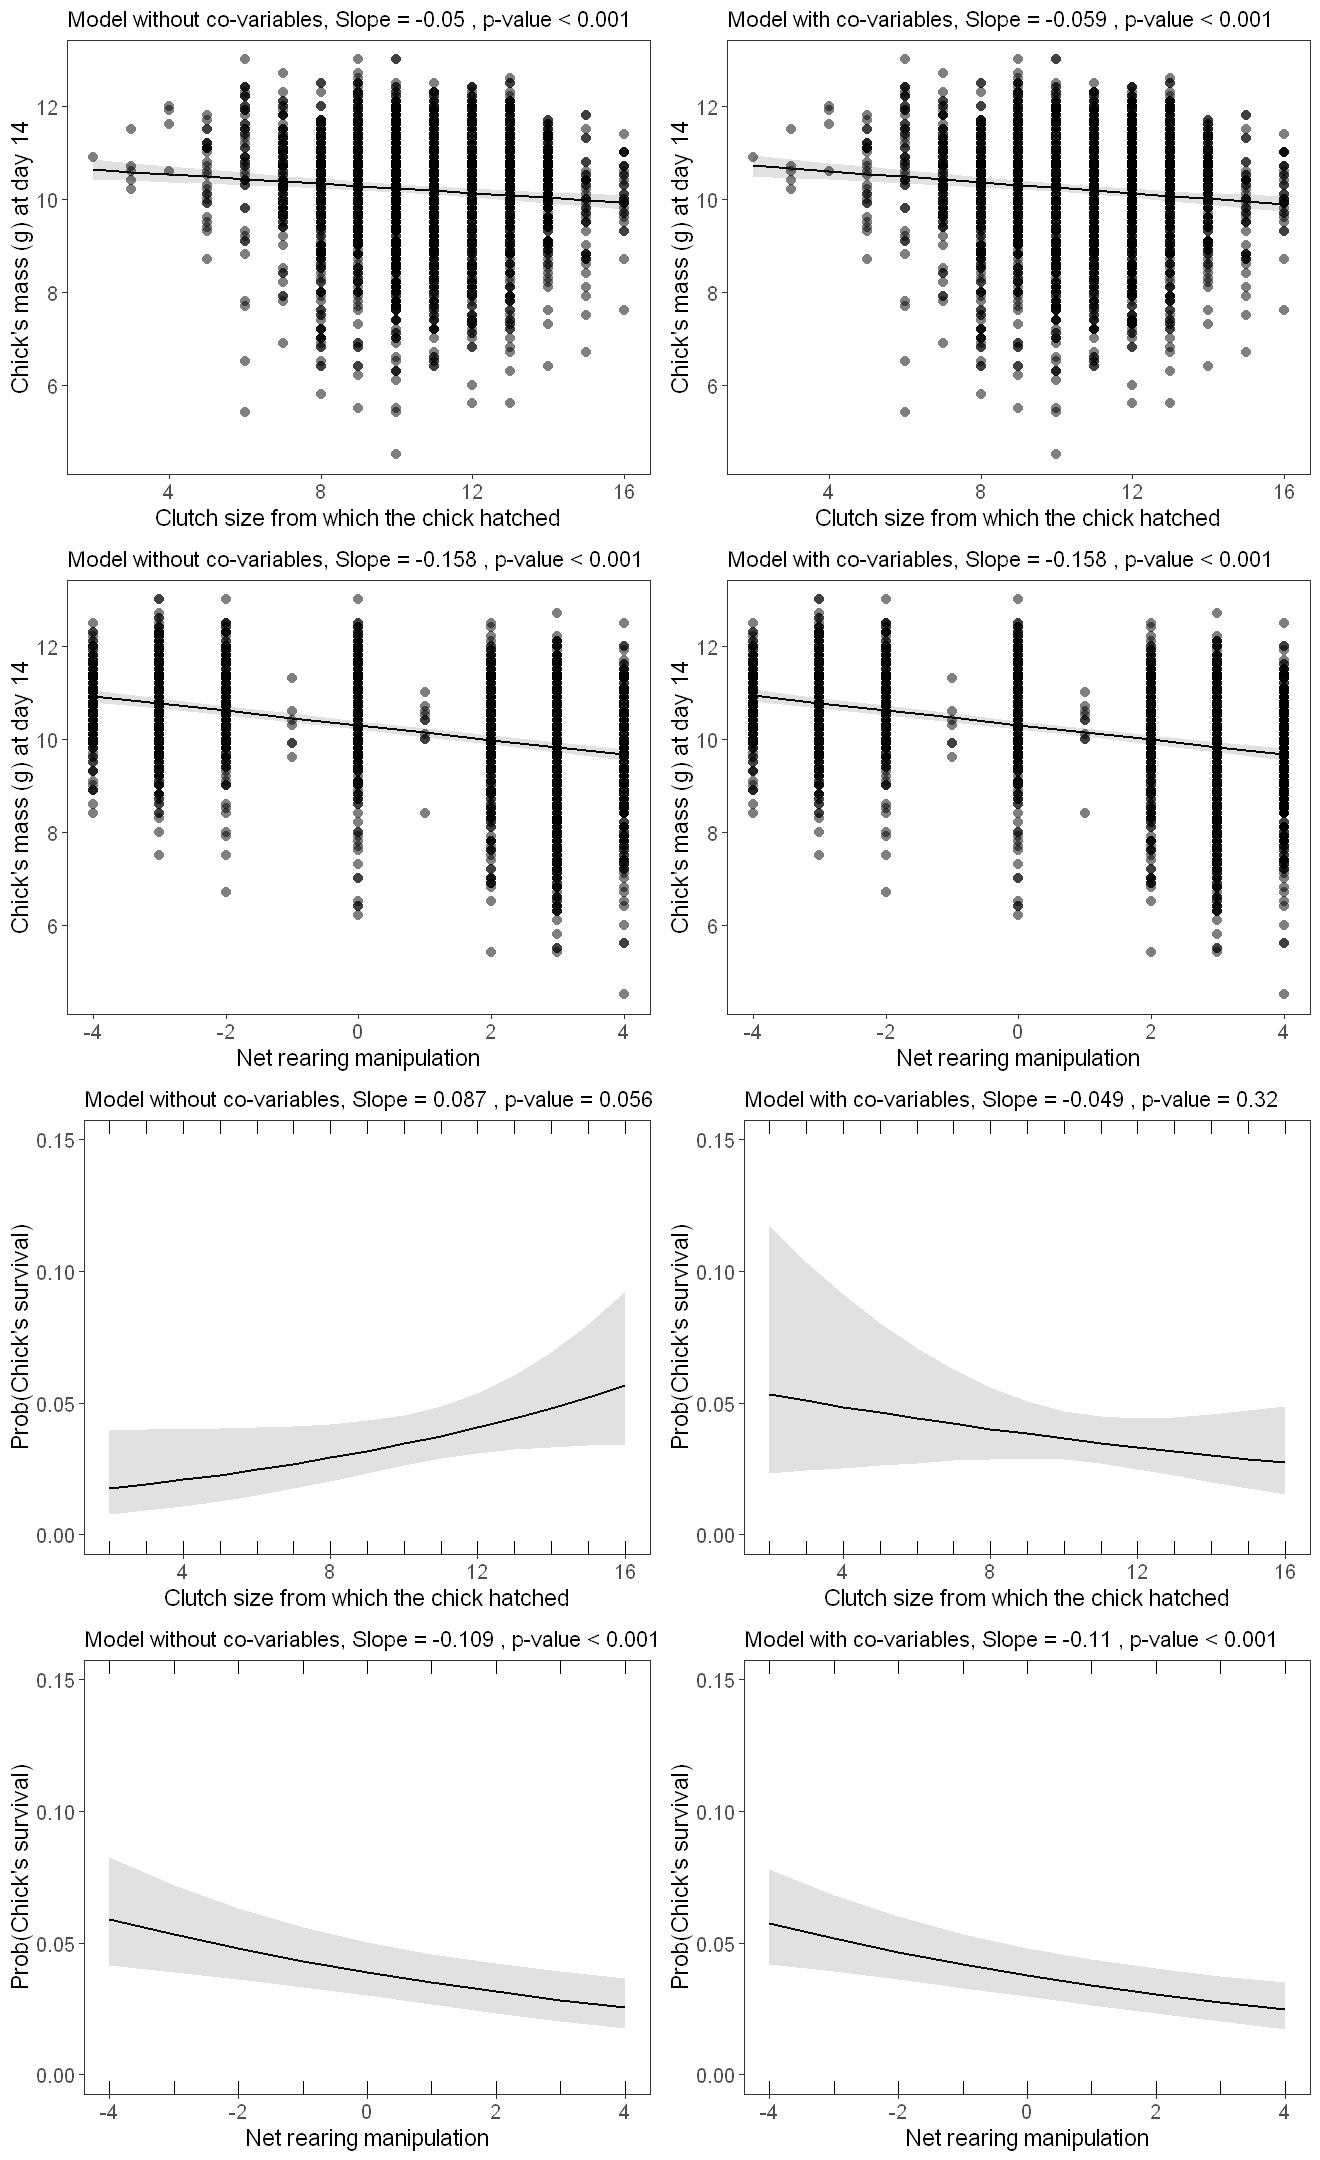

In [44]:
options(repr.plot.width=11, repr.plot.height=18)

theme_set (theme_bw())
P1= plot_model (model_id_growth,type="eff",show.data=TRUE)$hatch_nest_CS
P1= P1+theme(panel.grid.major = element_blank(),panel.grid.minor = element_blank(),
            axis.text=element_text(size=12),axis.title=element_text(size=14))+
    labs(y="Chick's mass (g) at day 14",x="Clutch size from which the chick hatched")+ 
    ggtitle(paste("Model without co-variables,",
                  "Slope =", round(Summary_MIG$coefficients[2,1],3),
                  ", p-value", ifelse(sig1<0.001,
                                      "< 0.001",paste("=",round(sig1,3)))
                 ))

P2= plot_model (model_id_growth_cov,type="eff",show.data=TRUE)$hatch_nest_CS
P2= P2+theme(panel.grid.major = element_blank(),panel.grid.minor = element_blank(),
            axis.text=element_text(size=12),axis.title=element_text(size=14))+
    labs(y="Chick's mass (g) at day 14",x="Clutch size from which the chick hatched")+ 
    ggtitle(paste("Model with co-variables,",
                  "Slope =", round(Summary_MIG_cov$coefficients[2,1],3),
                  ", p-value", ifelse(sig1_cov<0.001,
                                      "< 0.001",paste("=",round(sig1_cov,3)))
                 ))

P3= plot_model (model_id_growth,type="eff",show.data=TRUE)$net_rearing_manipulation
P3= P3+theme(panel.grid.major = element_blank(),panel.grid.minor = element_blank(),
            axis.text=element_text(size=12),axis.title=element_text(size=14))+
    labs(y="Chick's mass (g) at day 14",x="Net rearing manipulation")+ 
    ggtitle(paste("Model without co-variables,",
                  "Slope =", round(Summary_MIG$coefficients[3,1],3),
                  ", p-value", ifelse(sig2<0.001,
                                      "< 0.001",paste("=",round(sig2,3)))
                 ))

P4= plot_model (model_id_growth_cov,type="eff",show.data=TRUE)$net_rearing_manipulation
P4= P4+theme(panel.grid.major = element_blank(),panel.grid.minor = element_blank(),
            axis.text=element_text(size=12),axis.title=element_text(size=14))+
    labs(y="Chick's mass (g) at day 14",x="Net rearing manipulation")+ 
    ggtitle(paste("Model with co-variables,",
                  "Slope =", round(Summary_MIG_cov$coefficients[3,1],3),
                  ", p-value", ifelse(sig2_cov<0.001,
                                      "< 0.001",paste("=",round(sig2_cov,3)))
                 ))

P5= plot_model (model_id_surv,type="eff")$hatch_nest_CS
P5= P5+theme(panel.grid.major = element_blank(),panel.grid.minor = element_blank(),
            axis.text=element_text(size=12),axis.title=element_text(size=14))+
    labs(y="Prob(Chick's survival)",x="Clutch size from which the chick hatched")+
    ylim(0, 0.15)+geom_rug(sides='tb')+
    ggtitle(paste("Model without co-variables,",
                  "Slope =", round(Summary_MIDsurv$coefficients[2,1],3),
                  ", p-value", ifelse(Summary_MIDsurv$coefficients[2,4]<0.001,
                                      "< 0.001",paste("=",round(Summary_MIDsurv$
                                                                coefficients[2,4],3)))
                 ))

P6= plot_model (model_id_surv_cov,type="eff")$hatch_nest_CS
P6= P6+theme(panel.grid.major = element_blank(),panel.grid.minor = element_blank(),
            axis.text=element_text(size=12),axis.title=element_text(size=14))+
    labs(y="Prob(Chick's survival)",x="Clutch size from which the chick hatched")+
    ylim(0, 0.15)+geom_rug(sides='tb')+
    ggtitle(paste("Model with co-variables,",
                  "Slope =", round(Summary_MIDsurv_cov$coefficients[2,1],3),
                  ", p-value", ifelse(Summary_MIDsurv_cov$coefficients[2,4]<0.001,
                                      "< 0.001",paste("=",round(Summary_MIDsurv_cov$
                                                                coefficients[2,4],3)))
                 ))

P7= plot_model (model_id_surv,type="eff")$net_rearing_manipulation
P7= P7+theme(panel.grid.major = element_blank(),panel.grid.minor = element_blank(),
            axis.text=element_text(size=12),axis.title=element_text(size=14))+
    labs(y="Prob(Chick's survival)",x="Net rearing manipulation")+
    ylim(0, 0.15)+geom_rug(sides='tb')+
    ggtitle(paste("Model without co-variables,",
                  "Slope =", round(Summary_MIDsurv$coefficients[3,1],3),
                  ", p-value", ifelse(Summary_MIDsurv$coefficients[3,4]<0.001,
                                      "< 0.001",paste("=",round(Summary_MIDsurv$
                                                                coefficients[3,4],3)))
                 ))

P8= plot_model (model_id_surv_cov,type="eff")$net_rearing_manipulation
P8= P8+theme(panel.grid.major = element_blank(),panel.grid.minor = element_blank(),
            axis.text=element_text(size=12),axis.title=element_text(size=14))+
    labs(y="Prob(Chick's survival)",x="Net rearing manipulation")+
    ylim(0, 0.15)+geom_rug(sides='tb')+
    ggtitle(paste("Model with co-variables,",
                  "Slope =", round(Summary_MIDsurv_cov$coefficients[3,1],3),
                  ", p-value", ifelse(Summary_MIDsurv_cov$coefficients[3,4]<0.001,
                                      "< 0.001",paste("=",round(Summary_MIDsurv_cov$
                                                                coefficients[3,4],3)))
                 ))

plot_grid (P1,P2,P3,P4,P5,P6,P7,P8,nrow=4,ncol=2)

These results indicate that chicks’ mass (a proxy for growth) is negatively associated with clutch size and also with the net hearing manipulation (i.e. adding more chicks in the nests leads to lower chicks’ mass). These results were consistent either in the presence or not of influential co-variables. Net rearing manipulation was also negatively associated with chicks' survival, indicating that higher numbers of chicks in the nests lead to lower levels of survivorship. On the other hand, clutch size had a positive marginally significant relationship with chick's survivorship when models without co-variables were used. This result switch to a negative non-significant relationship when models with co-variables were used. What happened? Well, the answer is probably related to the inclusion of the co-variable "hatch_nest_LD", which describes the date of the first egg was laid ('lay date') in the clutch from which the chick hatched (April 1 = 1). Let's take a look at the relationship between these two variables below. 

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



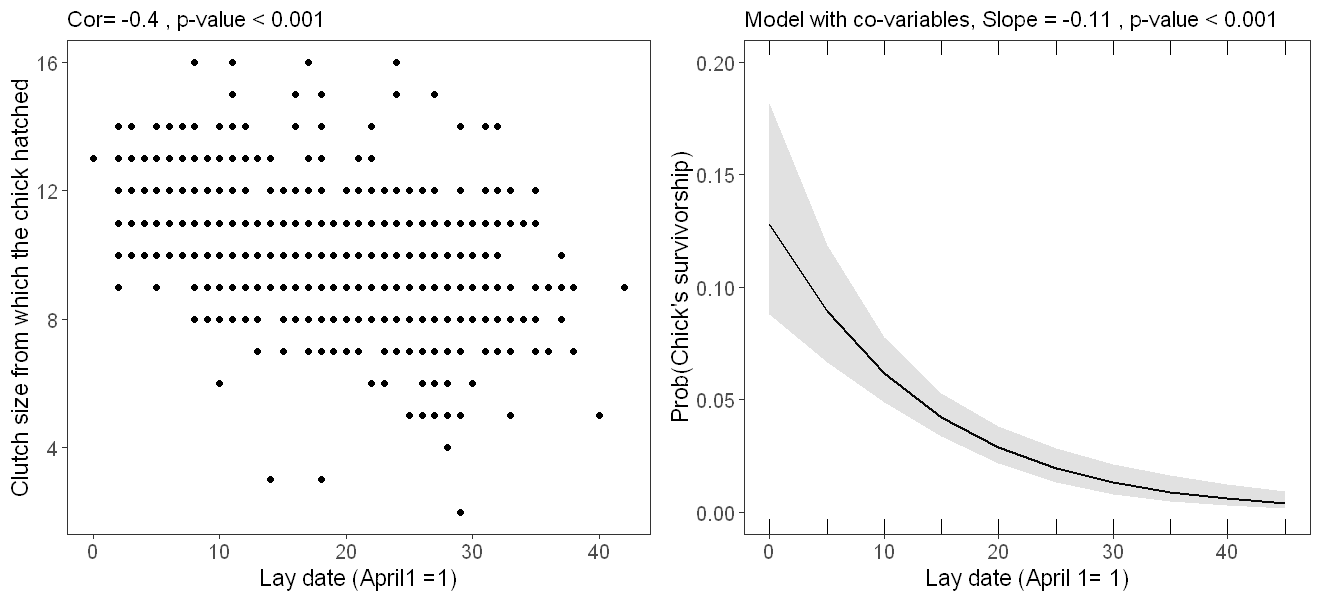

In [45]:
options(repr.plot.width=11, repr.plot.height=5)
cor_test5=cor.test (ind_data$hatch_nest_CS,ind_data$rear_nest_LD)

P9= ggplot (ind_data,aes(y=hatch_nest_CS,x=rear_nest_LD))+
    geom_point()+
    theme(panel.grid.major = element_blank(),panel.grid.minor = element_blank(),
            axis.text=element_text(size=12),axis.title=element_text(size=14))+
    labs(y="Clutch size from which the chick hatched",x="Lay date (April1 =1)")+
    ggtitle(paste("Cor=", round(cor_test5$estimate,2),
                  ", p-value", ifelse(cor_test5$p.value<0.001,
                                     "< 0.001",round(cor_test5$p.value,3))))
    
P10= plot_model (model_id_surv_cov,type="eff")$rear_nest_LD
P10= P10+theme(panel.grid.major = element_blank(),panel.grid.minor = element_blank(),
            axis.text=element_text(size=12),axis.title=element_text(size=14))+
    labs(y="Prob(Chick's survivorship)",x="Lay date (April 1= 1)")+
     ylim(0, 0.20)+geom_rug(sides='tb')+
    ggtitle(paste("Model with co-variables,",
                  "Slope =", round(Summary_MIDsurv_cov$coefficients[3,1],3),
                  ", p-value", ifelse(Summary_MIDsurv_cov$coefficients[3,4]<0.001,
                                      "< 0.001",paste("=",round(Summary_MIDsurv_cov$
                                                                coefficients[3,4],3)))
                 ))

plot_grid(P9,P10,nrow=1,ncol=2)

The figures above show that clutch size is responding to a seasonal (environmental) gradient. Clutch sizes are larger during the Spring than during the Summer. Interestingly, chicks survivorship is also higher during Spring. In this sense, birds are probably nesting during the most favorable period of the year. After controlling for this seasonal gradient, clutch size returns to its expected negative relationship with survivorship, however, this relationship seems weak and non-significant.  